In [1]:
# Import useful things

import numpy as np      
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import rcParams
import matplotlib.dates as md

# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 14}) 
rcParams['axes.titlepad'] = 14 
rcParams['xtick.major.pad']='8'
rcParams['ytick.major.pad']='8'

# Supress warnings for notebook ease of use
import warnings
warnings.filterwarnings("ignore")

In [2]:

def get_flux_estimations(start,stop,d_loc,avp):
    f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')
    flux_out = pd.DataFrame(columns=['SHF', 'LHF', 'MOMFU', 'QC_LHF', 'QC_SHF', 'QC_MOMFU'])
    QC_out = pd.DataFrame(columns=['Dates','skew_u','skew_v','skew_w','skew_T','skew_q','kurt_u','kurt_v','kurt_w','kurt_T','kurt_q','sst_wu','sst_wv','sst_wt','sst_wq','Obukhov','BowenRatio','FrictionU','ZoverL','sigma_w','itc_w','quality_wu','quality_wv','quality_wt','quality_wq'])
    for date in f_date_list: 
        f1 = d_loc + r'Flux_estimates/Flux_estimates_%smin_%s.csv'%(avp,str(date.date()))
        f2 = d_loc + r'Flux_QC/Flux_QC_%smin_%s.csv'%(avp,str(date.date()))                      
        try:
            data = pd.read_csv(f1,parse_dates=[0],index_col=[0])
            qc_dat = pd.read_csv(f2,parse_dates=[0],index_col=[0])
        except:
            print('No data for %s'%str(date.date()))
            continue

        flux_out = flux_out.append(data,sort=True)
        QC_out = QC_out.append(qc_dat,sort=True)

    # Get rid of any duplicates
    flux_out = flux_out[~flux_out.index.duplicated()]
    QC_out = QC_out[~QC_out.index.duplicated()]

    # Crop to datetime
    flux_out=flux_out[start:stop]
    QC_out=QC_out[start:stop]
    
    return flux_out,QC_out
      
def qc_flux(flux,qc_lev):
    qcd = flux.copy()
    qcd['LHF'][flux['QC_LHF']==0]=np.nan
    qcd['SHF'][flux['QC_SHF']==0]=np.nan
    qcd['MOMFU'][flux['QC_MOMFU']==0]=np.nan
    if qc_lev==1: 
        qcd['LHF'][flux['QC_LHF']==2]=np.nan
        qcd['SHF'][flux['QC_SHF']==2]=np.nan
        qcd['MOMFU'][flux['QC_MOMFU']==2]=np.nan      
    
    return qcd

In [3]:
# Flux directory
d_loc = '/Volumes/Data/ICECAPSarchive/fluxtower/processed/TurbulentFluxes/'

# date range
start = dt.datetime(2019,7,29,0,0,0)
stop = dt.datetime(2019,7,29,23,0,0)

avp=15
# Get flux estimates and qc data
#flux_15, QC_15 = get_flux_estimations(start,stop,d_loc,15)
#flux_30, QC_30 = get_flux_estimations(start,stop,d_loc,30)



In [4]:
# First get fluxes so you have the QC's

# Get flux estimates and qc data
flux, QC = get_flux_estimations(start,stop,d_loc,avp)

# QC flux data
# level 2 gives you all the 1 and 2 flagged data
# level 1 just gives you the 1 flagged data
flux_qcd = qc_flux(flux,1)

In [5]:
f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')
cols = pd.read_csv(d_loc + r'Cospectra/Ogive_wu_%smin_%s.csv'%(avp,str(start.date())), nrows=1).columns.tolist()
freqs = [float(i) for i in cols[1:]]
ogive_out = pd.DataFrame(columns=cols)

for date in f_date_list:
    f = d_loc + r'Cospectra/Ogive_wu_%smin_%s.csv'%(avp,str(date.date()))
    try:
        data = pd.read_csv(f,parse_dates=[0],index_col=[0])
    except:
        print('No data for %s'%str(date.date()))
        continue
        
    ogive_out = ogive_out.append(data,sort=True)
    
ogive_out = ogive_out[~ogive_out.index.duplicated()]
ogive_out = ogive_out[start:stop]
ogive_out = ogive_out.drop(['Dates'],axis=1)
ogive_standard = ogive_out.div(ogive_out[cols[1]],axis=0)

ogive_out_qcd = ogive_out.loc[flux_qcd.index[~np.isnan(flux_qcd['MOMFU'])]]
ogive_standard_qcd = ogive_standard.loc[flux_qcd.index[~np.isnan(flux_qcd['MOMFU'])]]

ogive_dates_qcd = flux_qcd.index[~np.isnan(flux_qcd['MOMFU'])]
ogive_dates = flux_qcd.index

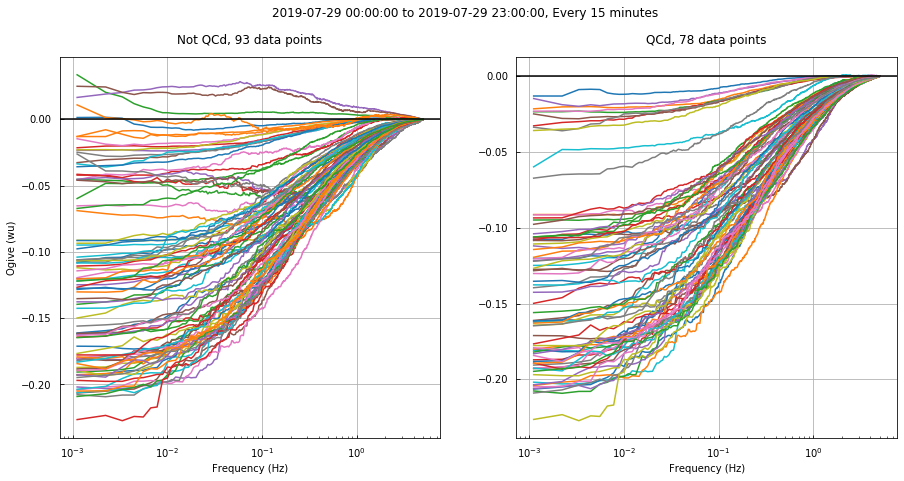

In [17]:
# Plot normal ogives (all on left, qc'd on right)

fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
ax1.grid(True)
for datetime in ogive_dates:
    og = ogive_out.loc[datetime]
    ax1.semilogx(freqs,og)

ax2 = fig.add_subplot(122)
ax2.grid(True)
for datetime in ogive_dates_qcd:
    og = ogive_out_qcd.loc[datetime]
    ax2.semilogx(freqs,og)

ax1.set_ylabel('Ogive (wu)')
ax2.set_xlabel('Frequency (Hz)')
ax1.set_xlabel('Frequency (Hz)')

ax1.set_title('Not QCd, %s data points'%len(ogive_out))
ax2.set_title('QCd, %s data points'%len(ogive_out_qcd))

ax1.axhline(0,c='k')
ax2.axhline(0,c='k')

fig.suptitle('%s to %s, Every %s minutes'%(str(start),str(stop),avp))

# Save location:
out_loc = '/Users/heather/Desktop/Ogive_plot_out/'
# For no save out_loc=False

# Savename option:
sname_op = ''

# Save if neccessary.
fig.savefig(out_loc + 'OGIVEwu_%s_%s_%smins'%(dt.datetime.strftime(start,'%y%m%d%H%M'),dt.datetime.strftime(stop,'%y%m%d%H%M'),avp) + sname_op + '.png')


In [7]:
og

0.0011111111111111111   -0.122068
0.0022222222222222222   -0.120618
0.003333333333333333    -0.119963
0.0044444444444444444   -0.118173
0.005555555555555556    -0.112248
                           ...   
4.995555555555556        0.000010
4.996666666666667        0.000006
4.997777777777778        0.000009
4.998888888888889        0.000013
5.0                      0.000000
Name: 2019-07-29 23:00:00, Length: 4500, dtype: float64

In [12]:
len(og)

4500

In [19]:
'OGIVEwu_%s_%s_%smins'%(dt.datetime.strftime(start,'%y%m%d%H%M'),dt.datetime.strftime(stop,'%y%m%d%H%M'),avp)

'OGIVEwu_1907290000_1907292300_15mins'

In [15]:
dt.datetime.strftime(start,'%y%m%d%H%M')

'1907290000'

Text(0.5, 17.200000000000003, 'Frequency (Hz)')

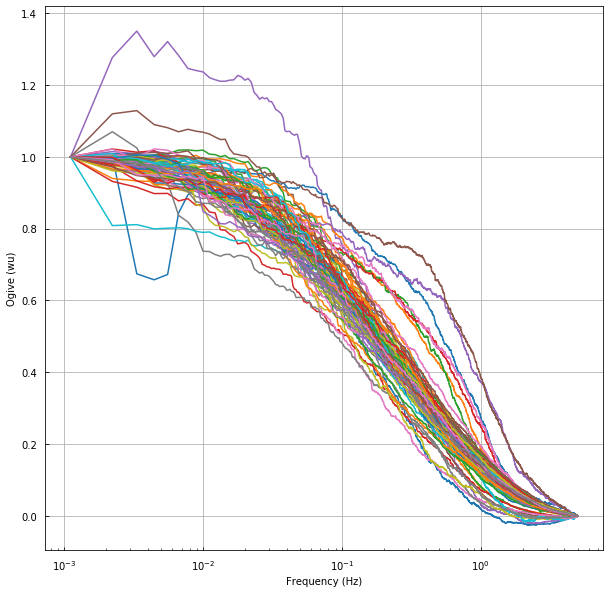

In [13]:

# Plot standardised ogives

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.set_ylabel('Ogive (wu)')
ax1.set_xlabel('Frequency (Hz)')

ogive_dates_qcd = flux_qcd.index[~np.isnan(flux_qcd['MOMFU'])]
ogive_dates = flux.index

for dat in ogive_dates_qcd:
    og = ogive_out.loc[dat]  
    og_stand = ogive_standard.loc[dat]  
    first_row = og.iloc[0]
    if np.abs(first_row)<0.01:
        continue
    #print(first_row)
    #ax1.semilogx(freqs,og)
    ax1.semilogx(freqs,og_stand)
ax2.set_ylabel('Ogive (wu)')
ax2.set_xlabel('Frequency (Hz)')
#ax2.set_title('Every 15 minutes')

# Save if neccessary

In [15]:
og_stand

0.0011111111111111111    1.000000
0.0022222222222222222    0.988125
0.003333333333333333     0.982755
0.0044444444444444444    0.968095
0.005555555555555556     0.919552
                           ...   
4.995555555555556       -0.000080
4.996666666666667       -0.000053
4.997777777777778       -0.000070
4.998888888888889       -0.000110
5.0                     -0.000000
Name: 2019-07-29 23:00:00, Length: 4500, dtype: float64

[Text(1, 0, '0'),
 Text(1, 0, '10'),
 Text(1, 0, '20'),
 Text(1, 0, '30'),
 Text(1, 0, '40'),
 Text(1, 0, '50'),
 Text(1, 0, '60'),
 Text(1, 0, '70'),
 Text(1, 0, '80'),
 Text(1, 0, '90'),
 Text(1, 0, '100')]

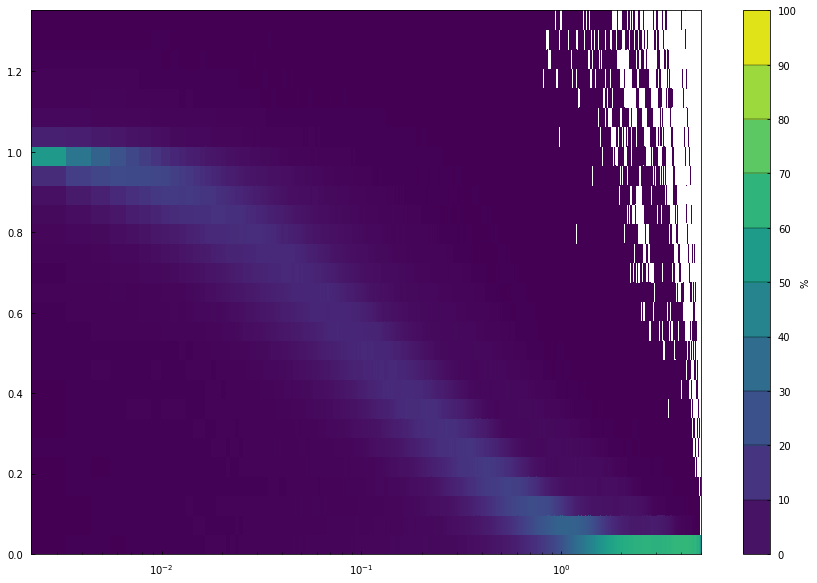

In [217]:

# Plot ogive density spectra

nbins = 30
bins = np.linspace(0.0,1.4,nbins)

hists = []
for i in range(1, len(freqs)):
    hists.append(np.histogram(ogive_standard_qcd[cols[i]], bins=bins)[0])
    
twodarr = np.array(hists)

nlines = len(ogive_standard_qcd)
percents = [0,10,20,30,40,50, 60, 70, 80, 90, 100]
boundaries=[]
for i in range(0,len(percents)):
    boundaries.append(nlines/100 * percents[i])
    
twodarr = np.ma.masked_where(twodarr == 0, twodarr)

y,x = np.meshgrid(bins[0:-1],freqs)

cmap = plt.cm.viridis
cmap.set_bad(color='white')

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111, xscale='log')
im = ax1.pcolormesh(x,y,twodarr,cmap=cmap)
#ax1.grid(True)
ax1.set_xlim(freqs[1], freqs[-1])
# plot 15 minues
#ax1.axvline(1/(15.0*60))
cbar = fig.colorbar(im, ax = ax1, drawedges=True,boundaries=boundaries,ticks=boundaries,label='%')
cbar.ax.set_yticklabels(percents)

# Save if neccessary. 



In [6]:
# Work on normalising for ubar
